In [3]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install SciPy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow
import os
import statistics as stats
from collections import defaultdict
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten,InputLayer, BatchNormalization, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model                                                        

In [6]:
##create a generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                          
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [8]:
##datasets splicings
train_dataset  = train_datagen.flow_from_directory(directory = 'breast_data/Data/train',
                                                   target_size = (75,75),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = 'breast_data/Data/valid',
                                                  target_size = (75,75),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = 'breast_data/Data/test',
                                                  target_size = (75,75),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [9]:
model_name = inception
input_t =(75,75, 3)
model = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune1 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune4 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

87916544/87910968 [==============================] - 4s 0us/step


In [10]:
# get the layer index
def getLayerIndex(model_i, layer_name):
    for pos, layer_g in enumerate(model_i.layers):
        if layer_g.name == layer_name:
            return pos


In [11]:
# get the convolved layers into an array for looping
convolved_layers = []

for layer in model.layers:

    t = np.array(layer.get_weights()).ndim
    array = np.array(layer.get_weights())
    if (model_name != resnet50) or (model_name != vgg16):
        if (len(array) > 0) and (t > 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))
    if (model_name == resnet50) or (model_name == vgg16):
        if len(array) > 0 and (t != 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))

# get the total number of weights in the array
total_layer_weights = 0
sum_positives = 0
sum_negatives = 0

# create a dictionary with layer index and positive values identified
layer_positives_dict = defaultdict(list)

# create a dictionary for storing the layers and their +ve values probabilities
layer_probs_dict = defaultdict(list)

In [12]:
# list the convolved layers
for c_layer in range(len(convolved_layers)):
    # create array for array matrices,feature values and convolved values for each layer
    layer_array_matrices = []
    layer_feature_sums = []
    layer_convolved_values_sum = []

    # get the arrays matrices(batches) pixel
    for i in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0])):
        # get the values for each feature
        ######print("channels(image):"+str(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])))
        for x in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])):
            # return all the values in the convolutional feature
            total_array = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x])
            # return all the negative values in the convolutional feature
            x2 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) < 0
            for c in range(len(x2)):
                ###print("all the trues in depth: " + str(c + 1) + " are for feature: " + str(x + 1))
                sum_negatives += sum(x2[c])
                # print(sum(x2[c]))
            # return all the values
            for y in range(len(total_array)):
                total_layer_weights += len(total_array[y])

            x1 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) > 0
            # get the values for each channel
            for a in range(len(x1)):
                value_pix = sum(x1[a])
                # get the positive values
                sum_positives += value_pix

                ######print(value_pix)
    list_sums = []
    list_sums.append((str(convolved_layers[c_layer]), sum_positives))
    layer_positives_dict.update(list_sums)

    # print the probabilities for each layer
    layer_pos_prob = sum_positives / total_layer_weights

    # create +ves values array
    positives_array = []
    for key, val in layer_positives_dict.items():
        # print(key, "corresponds to:",val," positive values")
        positives_array.append(val)
       
    list_layer_probs = []
    list_layer_probs.append((str(convolved_layers[c_layer]), layer_pos_prob))
    layer_probs_dict.update(list_layer_probs)

In [13]:
median_layer = stats.median(convolved_layers)

# create dictionary for storing selected median layers
second_layer_probs_dict = defaultdict(list)
# store the new list of layers to be matched with the mean probability
second_half_layers = []

# store all probabilities for the selected upper half layers
second_half_probs = []
# loop through the layers and print those layers above the median
for lyr, val in layer_probs_dict.items():
    # print(lyr, "Layer prob:", val)
    if int(lyr) > median_layer:
        # store the probabilities of the upper half selected convolved layers
        #print(lyr, "Layer prob:", val)
        # update the sum of selected layers probabilities
        second_half_probs.append(val)
        second_half_layers.append((lyr, val))
        second_layer_probs_dict.update(second_half_layers)

# get the mean of the layers
selected_layers_mean = stats.mean(second_half_probs)
final_selected_layers = []
# now get the final layers list whose value exceed the mean
for s_lyr, v in second_layer_probs_dict.items():
    # get the probabilities that are lower than the mean probability
    if v < selected_layers_mean:
        # store the probabilities of the upper half selected convolved layers
        final_selected_layers.append(s_lyr)

In [15]:
# for positive cosines similarities
pcs_h_layers =[29,210,252,263,268] #high cosine,,
pcs_l_layers =[4,11,289,290,291] #lower cosine
for sb_layer in model.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model, sb_layer.name)
    #for b in final_selected_layers:
    for b in pcs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for negative cosine similarities
# for model 2
# for positive cosines similarities
ncs_h_layers =[1,235,258,284,289,290]
ncs_l_layers =[4,11,14,44,51,74,77] #lower cosine
for sbs_layer in model2.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model2, sbs_layer.name)
    #for b in final_selected_layers:
    for b in ncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for positive negative cosine similarities
# for model 3
pncs_h_layers =[1,21,31,41,51,52,54] #high cosine,,
pncs_l_layers =[108,121,136,154,178] #lower cosine
for sbs_layer in model3.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model3, sbs_layer.name)
    #for b in final_selected_layers:
    for b in pncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)


#finetune by removeing the last layer
for lst_layer in model_tune1.layers[:-2]:
    lst_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 2nd last layer
for scnd_st_layer in model_tune2.layers[:-3]:
    scnd_st_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 3rd last layer
for thrd_layer in model_tune3.layers[:-4]:
    thrd_layer.trainable = False
    

    
####end of the last layer
#for feature extraction
for ftr_layer in model_tune4.layers:
    ftr_layer.trainable = False


conv2d_7 True
conv2d_67 True
conv2d_77 True
conv2d_76 True
conv2d_84 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True
mixed10 True


In [16]:

t_model = Sequential()
t_model.add(model)
t_model.add(Flatten())
#t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(64, activation='relu'))
t_model.add(layers.Dropout(0.5))
#t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model2 = Sequential()
t_model2.add(model2)
t_model2.add(Flatten())
#t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(64, activation='relu'))
t_model2.add(layers.Dropout(0.5))
#t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model3 = Sequential()
t_model3.add(model3)
t_model3.add(Flatten())
#t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(64, activation='relu'))
t_model3.add(layers.Dropout(0.5))
#t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model4 = Sequential()
t_model4.add(model_tune1)
t_model4.add(Flatten())
#t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(64, activation='relu'))
t_model4.add(layers.Dropout(0.5))
#t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(4, activation='softmax'))

#for model 2
t_model5 = Sequential()
t_model5.add(model_tune2)
t_model5.add(Flatten())
#t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(64, activation='relu'))
t_model5.add(layers.Dropout(0.5))
#t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(4, activation='softmax'))

#for model 2
t_model6 = Sequential()
t_model6.add(model_tune3)
t_model6.add(Flatten())
#t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(64, activation='relu'))
t_model6.add(layers.Dropout(0.5))
#t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model7 = Sequential()
t_model7.add(model_tune3)
t_model7.add(Flatten())
#t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(64, activation='relu'))
t_model7.add(layers.Dropout(0.5))
#t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(4, activation='softmax'))

In [17]:
#positive cosine similarity
t_model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history = t_model.fit(train_dataset,shuffle=True,validation_data=valid_dataset,epochs=100, verbose=1)

Epoch 1/100
10/10 [==============================] - 20s 911ms/step - loss: 1.5223 - accuracy: 0.2423 - val_loss: 1.4964 - val_accuracy: 0.2639
Epoch 2/100
10/10 [==============================] - 4s 431ms/step - loss: 1.4161 - accuracy: 0.2930 - val_loss: 1.4886 - val_accuracy: 0.2361
Epoch 3/100
10/10 [==============================] - 4s 442ms/step - loss: 1.3432 - accuracy: 0.3730 - val_loss: 1.5423 - val_accuracy: 0.1667
Epoch 4/100
10/10 [==============================] - 4s 423ms/step - loss: 1.2968 - accuracy: 0.3777 - val_loss: 1.5426 - val_accuracy: 0.1528
Epoch 5/100
10/10 [==============================] - 4s 428ms/step - loss: 1.2753 - accuracy: 0.4258 - val_loss: 1.4763 - val_accuracy: 0.1667
Epoch 6/100
10/10 [==============================] - 5s 457ms/step - loss: 1.2236 - accuracy: 0.4554 - val_loss: 1.4188 - val_accuracy: 0.2222
Epoch 7/100
10/10 [==============================] - 4s 427ms/step - loss: 1.1584 - accuracy: 0.5346 - val_loss: 1.3975 - val_accuracy: 0.236

Epoch 58/100
10/10 [==============================] - 4s 438ms/step - loss: 0.1601 - accuracy: 0.9441 - val_loss: 0.6477 - val_accuracy: 0.8472
Epoch 59/100
10/10 [==============================] - 4s 430ms/step - loss: 0.1825 - accuracy: 0.9607 - val_loss: 0.5752 - val_accuracy: 0.8472
Epoch 60/100
10/10 [==============================] - 5s 451ms/step - loss: 0.1285 - accuracy: 0.9618 - val_loss: 0.5309 - val_accuracy: 0.8750
Epoch 61/100
10/10 [==============================] - 4s 429ms/step - loss: 0.1539 - accuracy: 0.9514 - val_loss: 0.5227 - val_accuracy: 0.8889
Epoch 62/100
10/10 [==============================] - 4s 438ms/step - loss: 0.1482 - accuracy: 0.9587 - val_loss: 0.5989 - val_accuracy: 0.8611
Epoch 63/100
10/10 [==============================] - 4s 424ms/step - loss: 0.2218 - accuracy: 0.9377 - val_loss: 0.6133 - val_accuracy: 0.8611
Epoch 64/100
10/10 [==============================] - 4s 441ms/step - loss: 0.1910 - accuracy: 0.9479 - val_loss: 0.6622 - val_accuracy:

In [18]:
#negative cosine similarity look
#for model2
t_model2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history2 = t_model2.fit(train_dataset,shuffle=True,validation_data=valid_dataset,epochs=100, verbose=1)

Epoch 1/100
10/10 [==============================] - 14s 641ms/step - loss: 1.5398 - accuracy: 0.2411 - val_loss: 1.5025 - val_accuracy: 0.4167
Epoch 2/100
10/10 [==============================] - 4s 443ms/step - loss: 1.3828 - accuracy: 0.3601 - val_loss: 1.3756 - val_accuracy: 0.3889
Epoch 3/100
10/10 [==============================] - 4s 422ms/step - loss: 1.3268 - accuracy: 0.3775 - val_loss: 1.3665 - val_accuracy: 0.3194
Epoch 4/100
10/10 [==============================] - 4s 420ms/step - loss: 1.2362 - accuracy: 0.4448 - val_loss: 1.3173 - val_accuracy: 0.3611
Epoch 5/100
10/10 [==============================] - 4s 423ms/step - loss: 1.2082 - accuracy: 0.4406 - val_loss: 1.2957 - val_accuracy: 0.4167
Epoch 6/100
10/10 [==============================] - 4s 422ms/step - loss: 1.1477 - accuracy: 0.4982 - val_loss: 1.2763 - val_accuracy: 0.3889
Epoch 7/100
10/10 [==============================] - 5s 473ms/step - loss: 1.1053 - accuracy: 0.5029 - val_loss: 1.2731 - val_accuracy: 0.361

Epoch 58/100
10/10 [==============================] - 4s 431ms/step - loss: 0.1463 - accuracy: 0.9570 - val_loss: 0.8031 - val_accuracy: 0.6944
Epoch 59/100
10/10 [==============================] - 4s 442ms/step - loss: 0.2704 - accuracy: 0.9114 - val_loss: 0.7942 - val_accuracy: 0.7222
Epoch 60/100
10/10 [==============================] - 4s 442ms/step - loss: 0.1873 - accuracy: 0.9286 - val_loss: 0.7188 - val_accuracy: 0.7083
Epoch 61/100
10/10 [==============================] - 4s 440ms/step - loss: 0.1625 - accuracy: 0.9382 - val_loss: 0.5421 - val_accuracy: 0.7917
Epoch 62/100
10/10 [==============================] - 4s 438ms/step - loss: 0.2016 - accuracy: 0.9280 - val_loss: 0.4069 - val_accuracy: 0.8611
Epoch 63/100
10/10 [==============================] - 4s 423ms/step - loss: 0.1580 - accuracy: 0.9514 - val_loss: 0.3796 - val_accuracy: 0.8333
Epoch 64/100
10/10 [==============================] - 4s 417ms/step - loss: 0.1614 - accuracy: 0.9314 - val_loss: 0.3841 - val_accuracy:

In [19]:
#for model3
t_model3.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history3 = t_model3.fit(train_dataset,shuffle=True,validation_data=valid_dataset,epochs=100, verbose=1)

Epoch 1/100
10/10 [==============================] - 15s 654ms/step - loss: 1.4775 - accuracy: 0.2734 - val_loss: 1.4900 - val_accuracy: 0.2917
Epoch 2/100
10/10 [==============================] - 4s 427ms/step - loss: 1.3542 - accuracy: 0.3582 - val_loss: 1.4157 - val_accuracy: 0.2500
Epoch 3/100
10/10 [==============================] - 4s 424ms/step - loss: 1.3003 - accuracy: 0.4190 - val_loss: 1.4191 - val_accuracy: 0.2361
Epoch 4/100
10/10 [==============================] - 4s 433ms/step - loss: 1.3145 - accuracy: 0.4095 - val_loss: 1.3669 - val_accuracy: 0.2778
Epoch 5/100
10/10 [==============================] - 4s 418ms/step - loss: 1.1538 - accuracy: 0.5051 - val_loss: 1.3758 - val_accuracy: 0.2500
Epoch 6/100
10/10 [==============================] - 4s 426ms/step - loss: 1.0849 - accuracy: 0.5500 - val_loss: 1.4296 - val_accuracy: 0.2361
Epoch 7/100
10/10 [==============================] - 4s 421ms/step - loss: 1.0870 - accuracy: 0.5015 - val_loss: 1.4055 - val_accuracy: 0.305

Epoch 58/100
10/10 [==============================] - 5s 451ms/step - loss: 0.2273 - accuracy: 0.9313 - val_loss: 0.6353 - val_accuracy: 0.7778
Epoch 59/100
10/10 [==============================] - 4s 420ms/step - loss: 0.2694 - accuracy: 0.9108 - val_loss: 0.6539 - val_accuracy: 0.7639
Epoch 60/100
10/10 [==============================] - 4s 448ms/step - loss: 0.2265 - accuracy: 0.9259 - val_loss: 0.5882 - val_accuracy: 0.8194
Epoch 61/100
10/10 [==============================] - 4s 436ms/step - loss: 0.2173 - accuracy: 0.9135 - val_loss: 0.4863 - val_accuracy: 0.8611
Epoch 62/100
10/10 [==============================] - 5s 468ms/step - loss: 0.2117 - accuracy: 0.9109 - val_loss: 0.4800 - val_accuracy: 0.8333
Epoch 63/100
10/10 [==============================] - 5s 468ms/step - loss: 0.1957 - accuracy: 0.9318 - val_loss: 0.4524 - val_accuracy: 0.8611
Epoch 64/100
10/10 [==============================] - 5s 453ms/step - loss: 0.2230 - accuracy: 0.9215 - val_loss: 0.4672 - val_accuracy:

In [20]:
#for model3
t_model4.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history4= t_model4.fit(train_dataset,shuffle=True,validation_data=valid_dataset,epochs=100, verbose=1)

Epoch 1/100
10/10 [==============================] - 11s 635ms/step - loss: 2.0963 - accuracy: 0.2513 - val_loss: 1.5226 - val_accuracy: 0.2917
Epoch 2/100
10/10 [==============================] - 4s 427ms/step - loss: 1.6214 - accuracy: 0.3019 - val_loss: 1.4651 - val_accuracy: 0.2917
Epoch 3/100
10/10 [==============================] - 4s 445ms/step - loss: 1.4692 - accuracy: 0.3412 - val_loss: 1.3989 - val_accuracy: 0.2778
Epoch 4/100
10/10 [==============================] - 4s 438ms/step - loss: 1.4484 - accuracy: 0.3536 - val_loss: 1.3615 - val_accuracy: 0.3056
Epoch 5/100
10/10 [==============================] - 4s 430ms/step - loss: 1.3864 - accuracy: 0.3694 - val_loss: 1.3424 - val_accuracy: 0.2917
Epoch 6/100
10/10 [==============================] - 4s 419ms/step - loss: 1.3636 - accuracy: 0.3519 - val_loss: 1.3304 - val_accuracy: 0.3611
Epoch 7/100
10/10 [==============================] - 4s 445ms/step - loss: 1.3364 - accuracy: 0.3609 - val_loss: 1.3176 - val_accuracy: 0.361

Epoch 58/100
10/10 [==============================] - 4s 422ms/step - loss: 1.0332 - accuracy: 0.5431 - val_loss: 1.0156 - val_accuracy: 0.5972
Epoch 59/100
10/10 [==============================] - 4s 428ms/step - loss: 1.0707 - accuracy: 0.5539 - val_loss: 1.0312 - val_accuracy: 0.5972
Epoch 60/100
10/10 [==============================] - 4s 428ms/step - loss: 1.0361 - accuracy: 0.5353 - val_loss: 1.0310 - val_accuracy: 0.5417
Epoch 61/100
10/10 [==============================] - 4s 422ms/step - loss: 1.0673 - accuracy: 0.5174 - val_loss: 1.0280 - val_accuracy: 0.5556
Epoch 62/100
10/10 [==============================] - 4s 430ms/step - loss: 1.0565 - accuracy: 0.5249 - val_loss: 1.0268 - val_accuracy: 0.5417
Epoch 63/100
10/10 [==============================] - 4s 426ms/step - loss: 0.9886 - accuracy: 0.5708 - val_loss: 1.0229 - val_accuracy: 0.5556
Epoch 64/100
10/10 [==============================] - 4s 421ms/step - loss: 1.0000 - accuracy: 0.5616 - val_loss: 1.0298 - val_accuracy:

In [21]:
#for model3
t_model5.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history5 = t_model5.fit(train_dataset,shuffle=True,validation_data=valid_dataset,epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 11s 622ms/step - loss: 1.8910 - accuracy: 0.3048 - val_loss: 1.4096 - val_accuracy: 0.3750
Epoch 2/100
10/10 [==============================] - 4s 423ms/step - loss: 1.6881 - accuracy: 0.2830 - val_loss: 1.4050 - val_accuracy: 0.3472
Epoch 3/100
10/10 [==============================] - 4s 424ms/step - loss: 1.4937 - accuracy: 0.3329 - val_loss: 1.3686 - val_accuracy: 0.3750
Epoch 4/100
10/10 [==============================] - 4s 418ms/step - loss: 1.3867 - accuracy: 0.3397 - val_loss: 1.3464 - val_accuracy: 0.3472
Epoch 5/100
10/10 [==============================] - 4s 416ms/step - loss: 1.3598 - accuracy: 0.3512 - val_loss: 1.3012 - val_accuracy: 0.3611
Epoch 6/100
10/10 [==============================] - 4s 424ms/step - loss: 1.3026 - accuracy: 0.3649 - val_loss: 1.2899 - val_accuracy: 0.3611
Epoch 7/100
10/10 [==============================] - 4s 428ms/step - loss: 1.2522 - accuracy: 0.4501 - val_loss: 1.2889 - val_accuracy: 0.361

Epoch 58/100
10/10 [==============================] - 4s 433ms/step - loss: 1.0533 - accuracy: 0.5122 - val_loss: 1.0029 - val_accuracy: 0.5278
Epoch 59/100
10/10 [==============================] - 4s 416ms/step - loss: 1.0332 - accuracy: 0.5271 - val_loss: 1.0046 - val_accuracy: 0.5417
Epoch 60/100
10/10 [==============================] - 4s 424ms/step - loss: 0.9754 - accuracy: 0.5478 - val_loss: 1.0045 - val_accuracy: 0.5139
Epoch 61/100
10/10 [==============================] - 4s 428ms/step - loss: 0.9836 - accuracy: 0.5656 - val_loss: 1.0120 - val_accuracy: 0.4861
Epoch 62/100
10/10 [==============================] - 4s 448ms/step - loss: 1.0030 - accuracy: 0.5500 - val_loss: 0.9987 - val_accuracy: 0.4861
Epoch 63/100
10/10 [==============================] - 4s 418ms/step - loss: 1.0463 - accuracy: 0.5589 - val_loss: 0.9732 - val_accuracy: 0.5556
Epoch 64/100
10/10 [==============================] - 4s 425ms/step - loss: 0.9078 - accuracy: 0.6356 - val_loss: 0.9909 - val_accuracy:

In [22]:
#for model3
t_model6.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history6 = t_model6.fit(train_dataset,shuffle=True,validation_data=valid_dataset, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 11s 625ms/step - loss: 2.4676 - accuracy: 0.2152 - val_loss: 1.4897 - val_accuracy: 0.2639
Epoch 2/100
10/10 [==============================] - 4s 426ms/step - loss: 1.8219 - accuracy: 0.2652 - val_loss: 1.5291 - val_accuracy: 0.2917
Epoch 3/100
10/10 [==============================] - 4s 439ms/step - loss: 1.6397 - accuracy: 0.3296 - val_loss: 1.4196 - val_accuracy: 0.3194
Epoch 4/100
10/10 [==============================] - 4s 431ms/step - loss: 1.4808 - accuracy: 0.3588 - val_loss: 1.3397 - val_accuracy: 0.3333
Epoch 5/100
10/10 [==============================] - 4s 446ms/step - loss: 1.4885 - accuracy: 0.3477 - val_loss: 1.3141 - val_accuracy: 0.3889
Epoch 6/100
10/10 [==============================] - 4s 432ms/step - loss: 1.4172 - accuracy: 0.3547 - val_loss: 1.3129 - val_accuracy: 0.3472
Epoch 7/100
10/10 [==============================] - 4s 449ms/step - loss: 1.3821 - accuracy: 0.3600 - val_loss: 1.3005 - val_accuracy: 0.347

Epoch 58/100
10/10 [==============================] - 4s 425ms/step - loss: 1.0401 - accuracy: 0.5422 - val_loss: 1.0467 - val_accuracy: 0.5139
Epoch 59/100
10/10 [==============================] - 4s 430ms/step - loss: 1.0364 - accuracy: 0.5553 - val_loss: 1.0466 - val_accuracy: 0.5278
Epoch 60/100
10/10 [==============================] - 4s 415ms/step - loss: 0.9830 - accuracy: 0.5792 - val_loss: 1.0411 - val_accuracy: 0.5139
Epoch 61/100
10/10 [==============================] - 4s 428ms/step - loss: 1.0297 - accuracy: 0.5535 - val_loss: 1.0439 - val_accuracy: 0.5278
Epoch 62/100
10/10 [==============================] - 4s 421ms/step - loss: 0.9903 - accuracy: 0.5639 - val_loss: 1.0333 - val_accuracy: 0.5278
Epoch 63/100
10/10 [==============================] - 4s 429ms/step - loss: 1.0269 - accuracy: 0.5601 - val_loss: 1.0339 - val_accuracy: 0.5139
Epoch 64/100
10/10 [==============================] - 4s 429ms/step - loss: 0.9981 - accuracy: 0.5608 - val_loss: 1.0264 - val_accuracy:

In [23]:
#for model3
t_model7.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history7 = t_model7.fit(train_dataset, shuffle=True,validation_data=valid_dataset, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 11s 627ms/step - loss: 2.0410 - accuracy: 0.2595 - val_loss: 1.4139 - val_accuracy: 0.2917
Epoch 2/100
10/10 [==============================] - 4s 425ms/step - loss: 1.6854 - accuracy: 0.2933 - val_loss: 1.3383 - val_accuracy: 0.3333
Epoch 3/100
10/10 [==============================] - 4s 423ms/step - loss: 1.6238 - accuracy: 0.3058 - val_loss: 1.2872 - val_accuracy: 0.3472
Epoch 4/100
10/10 [==============================] - 4s 454ms/step - loss: 1.4546 - accuracy: 0.3432 - val_loss: 1.2574 - val_accuracy: 0.4028
Epoch 5/100
10/10 [==============================] - 4s 436ms/step - loss: 1.4503 - accuracy: 0.3196 - val_loss: 1.2297 - val_accuracy: 0.4028
Epoch 6/100
10/10 [==============================] - 4s 444ms/step - loss: 1.2882 - accuracy: 0.4023 - val_loss: 1.2162 - val_accuracy: 0.3889
Epoch 7/100
10/10 [==============================] - 4s 441ms/step - loss: 1.3081 - accuracy: 0.4124 - val_loss: 1.1972 - val_accuracy: 0.430

Epoch 58/100
10/10 [==============================] - 4s 439ms/step - loss: 1.0673 - accuracy: 0.5039 - val_loss: 1.0028 - val_accuracy: 0.5139
Epoch 59/100
10/10 [==============================] - 4s 449ms/step - loss: 1.0418 - accuracy: 0.5314 - val_loss: 0.9987 - val_accuracy: 0.5278
Epoch 60/100
10/10 [==============================] - 4s 432ms/step - loss: 1.0826 - accuracy: 0.4895 - val_loss: 0.9971 - val_accuracy: 0.4861
Epoch 61/100
10/10 [==============================] - 4s 429ms/step - loss: 1.0167 - accuracy: 0.5651 - val_loss: 0.9955 - val_accuracy: 0.5000
Epoch 62/100
10/10 [==============================] - 4s 423ms/step - loss: 0.9844 - accuracy: 0.5518 - val_loss: 0.9887 - val_accuracy: 0.5000
Epoch 63/100
10/10 [==============================] - 4s 465ms/step - loss: 1.0341 - accuracy: 0.5369 - val_loss: 0.9906 - val_accuracy: 0.5000
Epoch 64/100
10/10 [==============================] - 4s 425ms/step - loss: 1.0119 - accuracy: 0.5417 - val_loss: 0.9844 - val_accuracy:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


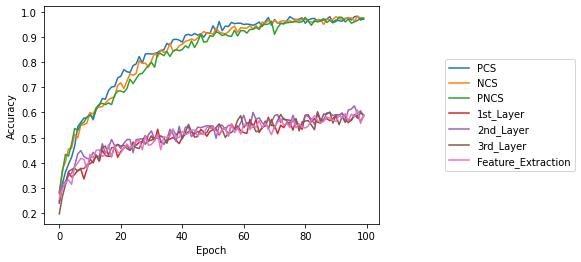

In [24]:
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['accuracy'])
#plt.plot(history3.history['val_loss'])
plt.plot(history4.history['accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history5.history['accuracy'])
#plt.plot(history5.history['val_loss'])
plt.plot(history6.history['accuracy'])
#plt.plot(history6.history['val_loss'])
plt.plot(history7.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc='lower right')
plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('all_similarity_breast_inceptionv3.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


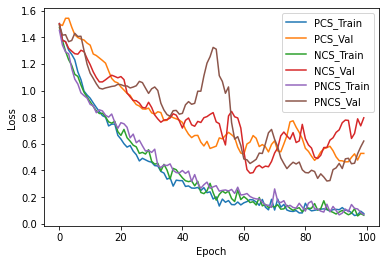

In [25]:
fig3 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PCS_Train','PCS_Val','NCS_Train','NCS_Val','PNCS_Train','PNCS_Val'], loc='upper right')

fig3.savefig('3plots_Loss_breast_inception.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


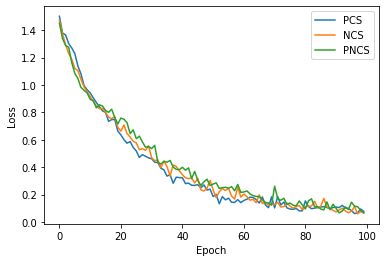

In [26]:
fig3 = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['loss'])
#plt.plot(history2.history['val_loss'])
plt.plot(history2.history['loss'])
#plt.plot(history3.history['val_loss'])
#plt.plot(history2.history['loss'])
#plt.plot(history4.history['val_loss'])
plt.plot(history3.history['loss'])
#plt.plot(history5.history['val_loss'])
#plt.plot(history3.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['PCS_Loss','PCS_Val_Loss','NCS_Loss','NCS_Val_Loss','PNCS_Loss','PNCS_Val_Loss'], loc='upper right')
#plt.legend(['PCS','NCS','PNCS'], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.legend(['PCS','NCS','PNCS'],  loc='upper right')
fig3.savefig('3plots_Loss_breast_data_inception.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


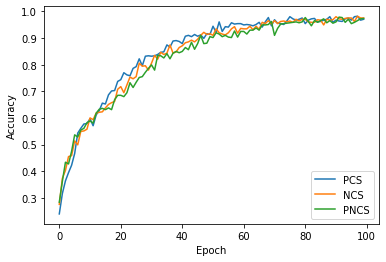

In [27]:
fig2 = plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history2.history['accuracy'])
#plt.plot(history3.history['val_loss'])
#plt.plot(history2.history['accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history3.history['accuracy'])
#plt.plot(history5.history['val_loss'])
#plt.plot(history3.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['PCS_Train','PCS_Val','NCS_Train','NCS_Val','PNCS_Train','PNCS_Val'], loc='upper left')
plt.legend(['PCS','NCS','PNCS'], loc='lower right')
#plt.legend(['PCS_Train','PCS_Val','NCS_Train'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig2.savefig('3plots_breast_inception.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()